# Document Classification - HR

In [2]:
# install necessary packages
!pip install -q -r requirements.txt

In [3]:
# Import necessary libraries and modules
import logging
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.WARNING)
logging.getLogger("sagemaker.config").setLevel(logging.WARNING)

import boto3
import sagemaker
import botocore
from io import BytesIO

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

import os
from utils import prepare_data,rf_model

In [4]:
def load_csv_from_s3(bucket_name, file_key, s3_client):
    obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    return pd.read_csv(BytesIO(obj['Body'].read()))

In [5]:
# Initialize S3 client 
s3_client = boto3.client(service_name='s3')
bucket_name = "docu-classification"  # identified bucket
print('S3 Bucket: {}'.format(bucket_name))

file_prefix = "data/"
datasets = {}
for filename in ["data", "train_data", "val_data", "test_data"]:
    file_key = f"{file_prefix}{filename}.csv"  
    try:
        datasets[filename] = load_csv_from_s3(bucket_name, file_key, s3_client) #load data file
        print(f"File {filename} loaded.")
    except Exception as e:
        print(f"Error occurred while uploading file: {e}")

#implement datasets
data = datasets["data"]
train_data = datasets["train_data"]
val_data = datasets["val_data"]
test_data = datasets["test_data"]

S3 Bucket: docu-classification
File data loaded.
File train_data loaded.
File val_data loaded.
File test_data loaded.


# 1. Preprocess

In [6]:
# Create the folder models inside the bucket
folder_name = 'models/'
try:
    # Uploading an empty file to create a folder-like prefix
    s3_client.put_object(Bucket=bucket_name, Key=folder_name)
    print(f"Folder '{folder_name}' created in bucket '{bucket_name}'.")
except Exception as e:
    print(f"Error occurred while creating the folder: {e}")
    
# # Create a folder named 'models' if it does not exist
# folder_name = 'models'
# if not os.path.exists(folder_name):
#     os.makedirs(folder_name)
#     print("Folder created.")

In model training data preparation, TF-IDF vectorization is used to convert text into numerical features by weighting words based on their relevance across documents. It moderates the impact of frequently occurring words to provide meaningful feature representation, with adjustments in max_features based on dataset size.

In [7]:
data.head()

,class,resume,resume_str,cleaned_resume,word_count
0,ACCOUNTANT,data/data/data/ACCOUNTANT/10554236.pdf,ACCOUNTANT\nSummary\nFinancial Accountant spec...,accountant summary financial accountant specia...,2242
1,ACCOUNTANT,data/data/data/ACCOUNTANT/10674770.pdf,STAFF ACCOUNTANT\nSummary\nHighly analytical a...,staff accountant summary highly analytical det...,767
2,ACCOUNTANT,data/data/data/ACCOUNTANT/11163645.pdf,ACCOUNTANT\nProfessional Summary\nTo obtain a ...,accountant professional summary obtain positio...,500
3,ACCOUNTANT,data/data/data/ACCOUNTANT/11759079.pdf,SENIOR ACCOUNTANT\nExperience\nCompany Name\n ...,senior accountant june 2011 current senior acc...,622
4,ACCOUNTANT,data/data/data/ACCOUNTANT/12065211.pdf,SENIOR ACCOUNTANT\nProfessional Summary\nSenio...,senior accountant professional summary senior ...,573


In [9]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def preprocess_dataset(data, text_column, label_column, dataset_isTrain = True, max_features=1000, sublinear_tf = True):
    """
    Function to preprocess a single dataset using TF-IDF for text data and encode labels.

    Args:
    data: DataFrame containing the dataset.
    text_column (str): Name of the column in DataFrame containing the text data.
    label_column (str): Name of the column in DataFrame containing the label data.
    max_features (int): Number of max features for TfidfVectorizer.

    Returns:
    X: Processed features.
    y_encoded: Encoded labels.
    """
    
    if dataset_isTrain == True:
        # Initialize the TF-IDF Vectorizer
        tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', sublinear_tf=sublinear_tf)
        X = tfidf_vectorizer.fit_transform(data[text_column])
        label_encoder = LabelEncoder() # Initialize the LabelEncoder (for predicted categories)     
        y_encoded = label_encoder.fit_transform(data[label_column]) # Transform the target var to numerical classes
        
        # Save the vectorizer and label encoder
        joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
        joblib.dump(label_encoder, 'models/label_encoder.pkl')
    
    else:
        # Load the TF-IDF Vectorizer
        tfidf_vectorizer = joblib.load('models/tfidf_vectorizer.pkl')
        X = tfidf_vectorizer.transform(data[text_column])
        # Load the LabelEncoder & transform data
        label_encoder = joblib.load('models/label_encoder.pkl')
        y_encoded = label_encoder.transform(data[label_column])

    
    return X, y_encoded


In [10]:
text_feature = "cleaned_resume"
target_feature = "class"

# Transform the test data into TF-IDF vectors
X_train,y_train = preprocess_dataset(train_data, text_feature, target_feature, 
                                     dataset_isTrain = True, max_features=768, sublinear_tf=False)
X_val, y_val = preprocess_dataset(val_data, text_feature, target_feature, 
                                  dataset_isTrain = False)
X_test, y_test = preprocess_dataset(test_data, text_feature, target_feature, 
                                  dataset_isTrain = False)

A high TF-IDF score indicates a word that is both frequent in a particular document and not very common in the corpus as a whole, making it a useful feature for distinguishing between documents.

In [ ]:
# Get the indices of non-zero features (words) in the k-th document (X_val[k])
k = 1235
non_zero_indices = X_train[k].nonzero()[1]

# Get the corresponding feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Show corresponding words and their TF-IDF score
print(f"Category: {label_encoder.classes_[y_train[k]]}")
for index in non_zero_indices:
    word = feature_names[index]
    score = X_train[k, index]
    print(f"Word : {word}, Score TF-IDF : {score}")

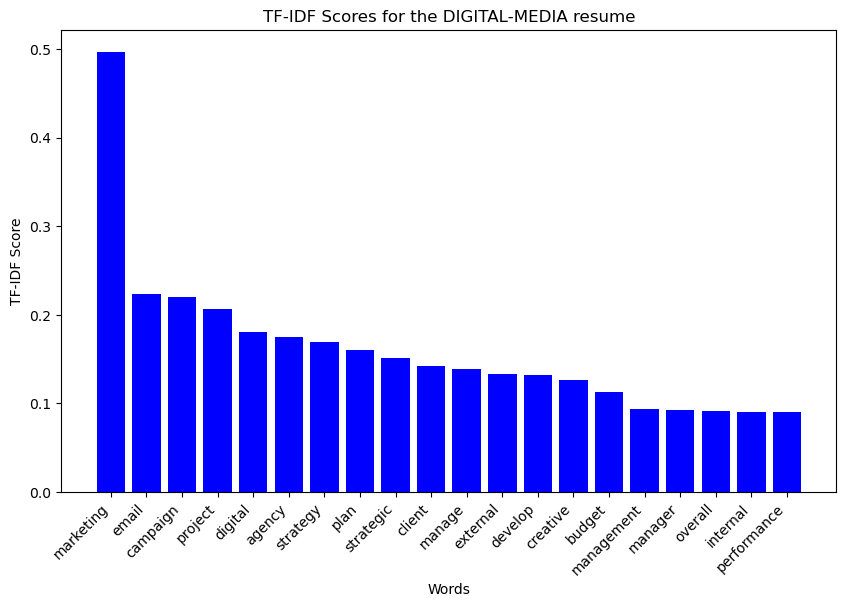

In [13]:
import matplotlib.pyplot as plt
tfidf_vectorizer = joblib.load("models/tfidf_vectorizer.pkl")
label_encoder = joblib.load("models/label_encoder.pkl")

k = 1235
# Get feature (words) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get non-zero indices for the first document in X_train
non_zero_indices = X_train[k].nonzero()[1]

# Get the corresponding TF-IDF scores
tfidf_scores = [X_train[k, index] for index in non_zero_indices]

# Get the corresponding words for these indices
words = [feature_names[index] for index in non_zero_indices]

# Combine words and scores into a list of tuples and sort them by score in descending order
word_score_pairs = sorted(zip(words, tfidf_scores), key=lambda x: x[1], reverse=True)
# Select the top 20 words and their scores
top_words, top_scores = zip(*word_score_pairs[:20])

# Create a bar plot for the TF-IDF scores
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(top_words, top_scores, color='blue')  # Create a bar plot

# Trouver la classe correspondant au numéro 16
class_label = label_encoder.inverse_transform([y_train[k]])

# Adding titles and labels
plt.title(f'TF-IDF Scores for the {class_label[0]} resume')  # Title of the plot
plt.xlabel('Words')  # X-axis label
plt.ylabel('TF-IDF Score')  # Y-axis label

# Rotate the words on X-axis for better visibility
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


# 2. Upload the preprocessing files to S3 bucket

In [15]:
# save pkl files in S3 bucket
file_names = ["models/" + filename + ".pkl" for filename in ["label_encoder", "tfidf_vectorizer"]]
s3_keys = ["models/" + filename + ".pkl" for filename in ["label_encoder", "tfidf_vectorizer"]]

for i in range(len(file_names)):
    local_file_path = file_names[i]
    s3_key = s3_keys[i]
    try:
        response = s3_client.upload_file(local_file_path, bucket_name, s3_key)
        print(f"File {local_file_path} uploaded to {bucket_name}/{s3_key}.")
    except Exception as e:
        print(f"Error occurred while uploading file: {e}")


File models/label_encoder.pkl uploaded to docu-classification/models/label_encoder.pkl.
File models/tfidf_vectorizer.pkl uploaded to docu-classification/models/tfidf_vectorizer.pkl.
